# Diffusion Model for the Oxford Flowers 102 Dataset 

## Introduction

### Oxford Flowers 102 Dataset

https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

102 category dataset, consisting of 102 flower categories. The flowers chosen to be flower commonly
occuring in the United Kingdom. Each class consists of between 40 and 258 images. The images have 
large scale, pose and light variations. In addition, there are categories that have large variations
within the category and several very similar categories.

There are a total of 8349 images, a total download in ~330Mb.

More information in the TensorFlow Datasets page:

https://www.tensorflow.org/datasets/catalog/oxford_flowers102


The package [github.com/gomlx/gomlx/examples/oxfordflowers102](http://github.com/gomlx/gomlx/examples/oxfordflowers102)
provides a `train.Dataset` object that can be used to train models with the dataset. It also provides a simplified
mechanism to download and cache the dataset.

### Diffusion Model

This notebook is an example of a diffusion model, bsed on he Keras example in:

https://keras.io/examples/generative/ddim/



In [1]:
!*go mod edit --replace github.com/gomlx/gomlx=${HOME}/Projects/gomlx

## Data Preprocessing

### Data directory and downloading the dataset

Bellow we call `DownloadAndParse`: it will only download if dataset files are not yet downloaded, otherwise it's a no-op.

This cell also defines some of the basics we will use later everywhere.

In [10]:
import (
    "flags"
    flowers "github.com/gomlx/gomlx/examples/oxfordflowers102"
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/types/shapes"
    "github.com/gomlx/gomlx/types/tensor"
    timage "github.com/gomlx/gomlx/types/tensor/image"
)


var (
    flagPlatform    = flag.String("platform", "", "Platform to use, if empty uses the default one.")
    flagDataDir = flag.String("data", "~/work/oxfordflowers102", "Directory to cache downloaded dataset and save checkpoints.")
    flagImageSize = flag.Int("size", 75, "Size of the images to use: since we'll cache them in the accelerator machine, it "+
                             "is limited by its memory. Largest value (the original image sizes) is 500.")
    flagBatchSize = flag.Int("batch", dogsvscats.DefaultConfig.BatchSize, "Batch size for training")
)

// DType used by the model.
var DType = shapes.F32 

var _ Graph  // Avoid error of `import . "gomlx/graph"` not used.

func AssertNoError(err error) {
    if err != nil {
        log.Fatalf("Failed: %+v", err)
    }
}

func MustNoError[T any](value T, err error) T {
    AssertNoError(err)
    return value
}

var manager *Manager

func init_manager() {
    flag.Parse()
    manager = BuildManager().Platform(*flagPlatform).MustDone()
}

%%
AssertNoError(flowers.DownloadAndParse(*flagDataDir))

### Sample of Flowers

To do that we create a temporry dataset (with `NewDataset`) of size 256x256 pixels, and then show a sample of the flowers.

Later we will use a model that uses only 64x64 pixels.

Example 2256:barbeton daisy (40)(256x256 pixels),Example 6030:ball moss (92)(256x256 pixels),Example 2180:thorn apple (74)(256x256 pixels),Example 6959:mexican aster (33)(256x256 pixels),Example 3451:fritillary (22)(256x256 pixels),Example 1428:petunia (50)(256x256 pixels)
Example 317:water lily (72)(256x256 pixels),Example 6721:toad lily (78)(256x256 pixels),Example 560:cyclamen (87)(256x256 pixels),Example 2958:pink-yellow dahlia? (59)(256x256 pixels),Example 5857:black-eyed susan (62)(256x256 pixels),Example 2321:sword lily (42)(256x256 pixels)
Example 5604:garden phlox (31)(256x256 pixels),Example 4471:canna lily (89)(256x256 pixels),Example 7099:globe thistle (9)(256x256 pixels),Example 5498:magnolia (86)(256x256 pixels),Example 4451:canna lily (89)(256x256 pixels),Example 7068:spring crocus (66)(256x256 pixels)
Example 280:water lily (72)(256x256 pixels),Example 3166:snapdragon (10)(256x256 pixels),Example 2818:bishop of llandaff (55)(256x256 pixels),Example 7517:bougainvillea (94)(256x256 pixels),Example 4661:buttercup (47)(256x256 pixels),Example 7274:japanese anemone (61)(256x256 pixels)

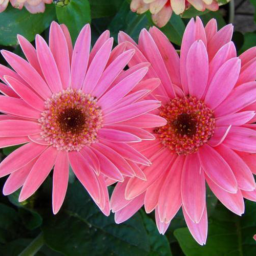
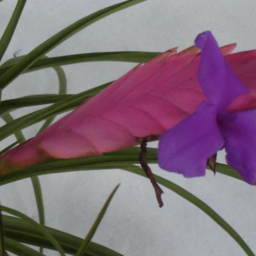
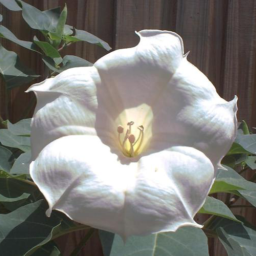
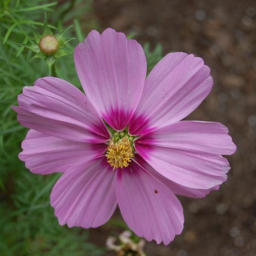
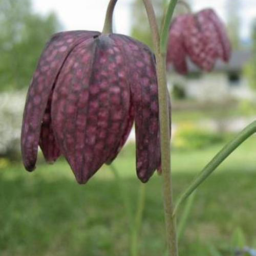
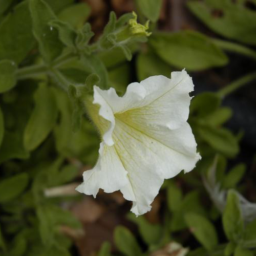
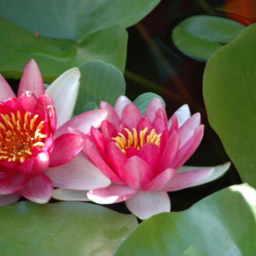
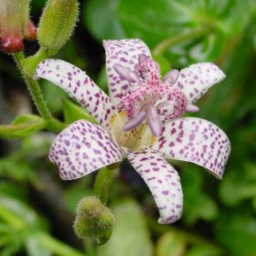
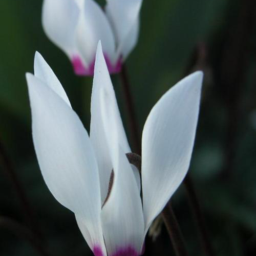
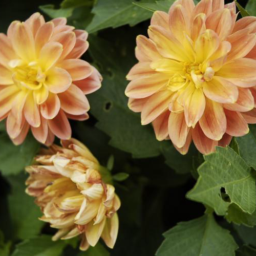
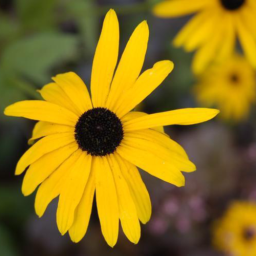
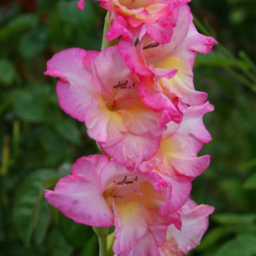
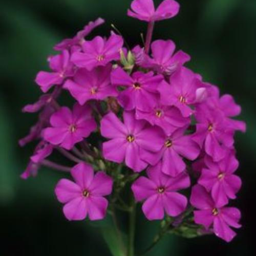
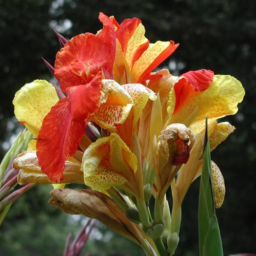
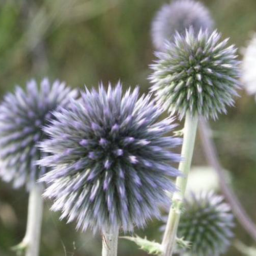
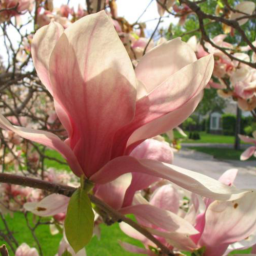
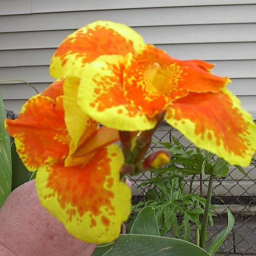
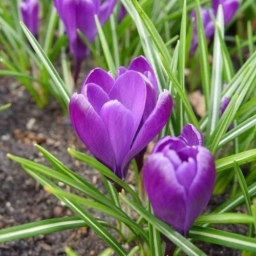
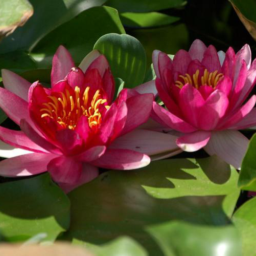
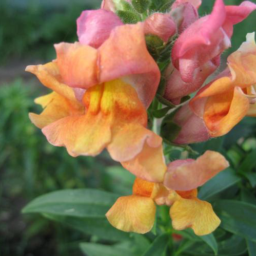
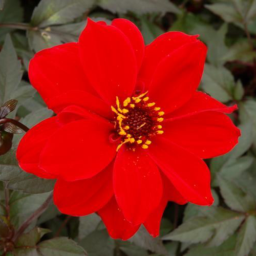
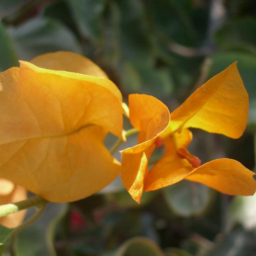
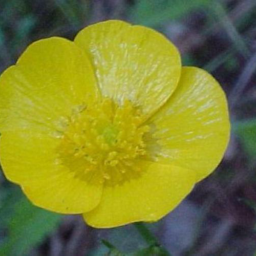
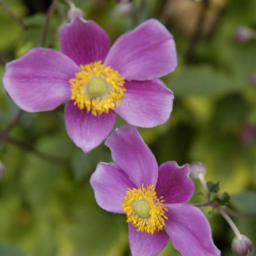

In [3]:

// sampleTable generates and outputs one html table of samples, sampling rows x cols from the images/labels provided.
func sampleTable(title string, ds train.Dataset, rows, cols int) {
    htmlRows := make([]string, 0, rows)
    for row := 0; row < rows; row++ {
        cells := make([]string, 0, cols)
        for col := 0; col < cols; col++ {
            cells = append(cells, sampleOneImage(ds))
        }
        htmlRows = append(htmlRows, fmt.Sprintf("<tr>\n\t<td>%s</td>\n</tr>", strings.Join(cells, "</td>\n\t<td>")))
    }
    htmlTable := fmt.Sprintf("<h4>%s</h4><table>%s</table>\n", title, strings.Join(htmlRows, ""))
    gonbui.DisplayHTML(htmlTable)
}

// sampleOneImage one image from tensor and returns an HTML rendered image with label
func sampleOneImage(ds train.Dataset) string {
    _, inputs, labels, err := ds.Yield()
    AssertNoError(err)
    imgTensor := inputs[0]
    img, err := timage.ToImage().Single(imgTensor)
    AssertNoError(err)
    exampleNum := inputs[1].Local().Value().(int)
    label := labels[0].Local().Value().(int32)
    labelStr := flowers.Names[label]
    
    imgSrc, err := gonbui.EmbedImageAsPNGSrc(img)
    AssertNoError(err)
    size := imgTensor.Shape().Dimensions[0]
    return fmt.Sprintf(`<figure style="padding:4px;text-align: center;"><img width="%d" height="%d" src="%s"><figcaption style="text-align: center;">Example %d:<br/><span>%s (%d)</span><br/>(%dx%d pixels)</figcaption></figure>`, 
                       size, size, imgSrc, exampleNum, labelStr, label, img.Bounds().Dx(), img.Bounds().Dy())
}

%% --size=256
AssertNoError(flowers.DownloadAndParse(*flagDataDir))
ds := flowers.NewDataset(shapes.U8, *flagImageSize)
ds.Shuffle()
sampleTable("Oxford 102 Flowers Sample", ds, 4, 6)
_ = BuildManager().MustDone()


### In-Memory Dataset for Fast Access

We convert the flowers dataset to `InMemory`, and cache its contents for faster start-up time.

The first time it runs it will read and convert all images to the target size. But it then saves a cache of the generated content, so the second time it is faster.

In [4]:
import (
    "encoding/gob"
    "github.com/gomlx/gomlx/ml/data"
)

const (
    PartitionSeed = int64(42) // Some arbitrary number.
    ValidationFraction = 0.2  // 20% of data.
)

// CreateInMemoryDatasets returns a train and a validation InMemoryDataset. 
func CreateInMemoryDatasets(manager *Manager) (trainDS, validationDS *data.InMemoryDataset, err error) {
    trainDS, err = flowers.InMemoryDataset(manager, *flagDataDir, *flagImageSize, "train", PartitionSeed, ValidationFraction, 1.0)
    if err != nil {
        return
    }
    validationDS, err = flowers.InMemoryDataset(manager, *flagDataDir, *flagImageSize, "validation", PartitionSeed, 0.0, ValidationFraction)    
    return 
}

// Remove cached file to force regeneratrion.
!rm -f "${HOME}/work/oxfordflowers102/"*_cached_images_*

%% --platform=Host
trainDS, validationDS, err := CreateInMemoryDatasets(manager)
AssertNoError(err)

fmt.Println()
fmt.Printf("Total number of examples: %d\n", flowers.NumExamples)
fmt.Printf("trainDS (in-memory) using %s of memory.\n", data.ByteCountIEC(trainDS.Memory()))
fmt.Printf("validationDS (in-memory) using %s of memory.\n", data.ByteCountIEC(validationDS.Memory()))


Creating InMemoryDataset for "train" with images cropped and scaled to 75x75...
	- 2.948403585s to process dataset.
Creating InMemoryDataset for "validation" with images cropped and scaled to 75x75...
	- 833.676618ms to process dataset.

Total number of examples: 8189
trainDS (in-memory) using 104.5 MiB of memory.
validationDS (in-memory) using 27.4 MiB of memory.


Example 2915:tree mallow (85)(75x75 pixels),Example 6261:cautleya spicata (60)(75x75 pixels),Example 7925:blanket flower (99)(75x75 pixels),Example 3727:primula (52)(75x75 pixels),Example 1648:clematis (81)(75x75 pixels),Example 2971:pink-yellow dahlia? (59)(75x75 pixels)

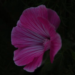
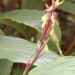
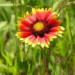
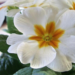
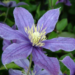
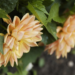

In [5]:
%%
trainDS, _, err := CreateInMemoryDatasets(manager)
AssertNoError(err)
trainDS.Shuffle()
sampleTable("Oxford 102 Flowers Sample -- In-Memory Dataset", trainDS, 1, 6)

### Bechmarking the Dataset

To make sure we are performant, and that the dataset doesn't become a bottleneck during training, we do some benchmarking below:

In [53]:
import (
    "time"
    "github.com/gomlx/gomlx/ml/data"
    "github.com/gomlx/gomlx/ml/train"
)

func finalize(tensors []tensor.Tensor) {
    for _, t := range tensors {
        t.FinalizeAll()
    }
}

func BenchmarkDataset(ds train.Dataset) {
    // Warm up, run 100 ds.Yield().
    for ii := 0; ii < 10; ii++ {
        _, inputs, labels, err := ds.Yield()
        AssertNoError(err)
        finalize(inputs)
        finalize(labels)
    }
    
    // Start benchmark.
    start := time.Now()
    count := 0
    for count < 100 {
        _, inputs, labels, err := ds.Yield()
        if err == io.EOF {
            break
        }
        AssertNoError(err)
        finalize(inputs)
        finalize(labels)
        count++
    }
    elapsed := time.Since(start)
    fmt.Printf("\t%d batches of %d examples read in %s\n", count, *flagBatchSize,elapsed)
}

%%
AssertNoError(flowers.DownloadAndParse(*flagDataDir))

fmt.Println("Directly reading from disk:")
ds := flowers.NewDataset(shapes.F32, *flagImageSize)
dsBatched := data.Batch(manager, ds, *flagBatchSize, true, true)
BenchmarkDataset(dsBatched)
dsBatched.Reset()

fmt.Printf("\nParallelized (%d cores) reading from disk:\n", runtime.NumCPU())
ds.Reset()
BenchmarkDataset(data.Batch(manager, data.Parallel(ds), *flagBatchSize, true, true))

fmt.Printf("\nInMemory dataset:\n")
manager := BuildManager().Platform(*flagPlatform).MustDone()
trainDS, _, err := CreateInMemoryDatasets(manager)
AssertNoError(err)
trainDS.BatchSize(*flagBatchSize, true)
BenchmarkDataset(trainDS)

Directly reading from disk:
	100 batches of 32 examples read in 10.508158838s

Parallelized (24 cores) reading from disk:
	100 batches of 32 examples read in 1.27183779s

InMemory dataset:
	100 batches of 32 examples read in 4.042273ms


## Denoising Diffusion Implicit Model

### Sinusoidal Embedding

Embeddings of the variance of the noise at different frequencies.

In [16]:
import . "github.com/gomlx/gomlx/graph"

var (
    flagEmbeddingDims = flag.Int("embedding_dim", 32, "Size of the embeddings, should be an even number")
    flagEmbeddingMaxFrequency = flag.Float64("embed_max_freq", 1000.0, "Embedding max frequency")
    flagEmbeddingMinFrequency = flag.Float64("embed_min_freq", 1.0, "Embedding max frequency")
)

func SinusoidalEmbedding(x *Node) *Node {
    g := x.Graph()
    if !g.Ok() {
        return g.InvalidNode()
    }

    // Generate geometrically spaced frequencies: only 1/2 of *flagEmbeddingDims because we use half for Sine, half for Cosine.
    halfEmbed := *flagEmbeddingDims/2
    logMinFreq := math.Log(*flagEmbeddingMinFrequency)
    logMaxFreq := math.Log(*flagEmbeddingMaxFrequency)
    frequencies := IotaFull(g, shapes.Make(x.DType(), halfEmbed))
    frequencies = AddScalar(
        MulScalar(frequencies, (logMaxFreq - logMinFreq) / float64(halfEmbed - 1.0)),
        logMinFreq)
    frequencies = Exp(frequencies)
    frequencies.AssertDims(halfEmbed)  // Geometrically spaced frequencies.

    // Generate sine/cosine embeddings.
    angularSpeeds := MulScalar(frequencies, 2.0 * math.Pi)
    angularSpeeds = ExpandLeftToRank(angularSpeeds, x.Rank())
    angles := Mul(angularSpeeds, x)
    return Concatenate([]*Node{Sin(angles), Cos(angles)}, -1)
}
                            
%%
value := MustNoError(NewExec(manager, func (g *Graph) *Node {
    return SinusoidalEmbedding(Const(g, [][][]float32{{{1.0}},{{2.0}}}))
}).Call())[0]
fmt.Printf("Shape: %s\nValue: %v\n", value.Shape(), value.Value())


Shape: (Float32)[2 1 32]
Value: [[[1.7484555e-07 -0.5084644 -0.074616365 -0.11864995 0.93075866 2.70213e-06 -0.8129459 0.6793376 -0.92810476 0.5659511 1.176251e-05 0.06701087 0.9265504 0.62322754 -0.26391345 0.0007279766 1 -0.86108303 -0.9972123 0.99293613 -0.3656342 1 0.5823393 0.73382586 0.37231916 0.8244388 1 -0.99775225 0.37617072 0.7820406 0.9645464 0.99999976]] [[3.496911e-07 0.8756602 0.1488167 -0.23562364 -0.6806344 5.40426e-06 -0.9468206 0.99703103 -0.6911024 0.9331841 2.352502e-05 -0.1337205 0.6970823 0.9747784 -0.50911355 0.0014559529 1 0.4829278 0.9888648 0.9718444 -0.7326233 1 -0.32176194 0.077000774 -0.72275686 0.35939878 1 0.99101907 -0.7169912 0.22317496 0.8606994 0.9999989]]]
